Le but de ce notebook est d'envisager un cas particulier : si on perd le contact avec un satellite ou que tout simplement celui-ci ne soit plus en mesure d'emettre pour la population, comment réorganiser le réseau deja existant afin de pouvoir garantir la couverture réseau ? 

Afin de résoudre ce problème, on va envisager plusieurs étapes : 
- tout d'abord on va essayer juste de trouver une solution existante avec N-1 satellites 
- par la suite, on va essayer de minimiser l'effort totale effectué par les satellites de l'état initial à l'état final, cela se fera en trouvant la disposition qui minimise la distance entre l'état initial et l'état final

In [158]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import numba
from sklearn.cluster import KMeans

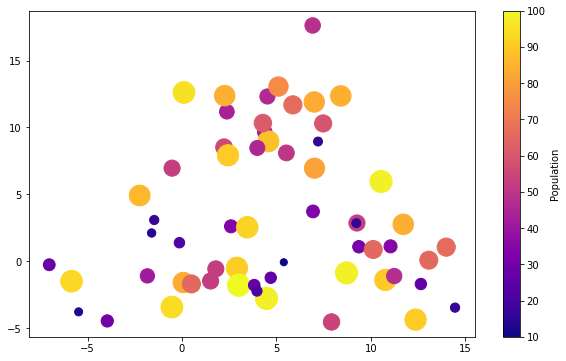

In [159]:
centers = np.array([[0, 0], [10, 0], [5, 10]])

# Générer les points à l'intérieur de chaque cluster
points_per_cluster = 20
points = []

for center in centers:
    # Générer des points aléatoires autour du centre du cluster
    cluster_points = np.random.normal(loc=center, scale=3, size=(points_per_cluster, 2))
    points.extend(cluster_points)

points = np.array(points)
xp = points[:, 0]
yp = points[:, 1]


population = np.random.randint(10, 101, size = 3*20)
size = population*5
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(xp, yp, c=population, cmap='plasma',
                s=size, zorder=3)
plt.colorbar(sc, label='Population')


In [160]:
Hs = 1
N = 18
n_clusters = 3
Is = 10
Imin = 0.1
ImaxSol = Imin*2

I_min_sol = 5
p = 100

In [161]:
@numba.jit(nopython = True)
def sigmoid(x, center = 0, M = 100) : 
    return 1/(1+np.exp(-M*(x-center)))

@numba.jit(nopython = True)
def pyth(x1, x2, y1, y2) : 
    return (x2-x1)**2 + (y2-y1)**2

In [162]:
x_min = np.min(xp)
x_max = np.max(xp)

y_min = np.min(yp)
y_max = np.max(yp)

@numba.jit(nopython = True, parallel = True)
def objectif(x) :
    return 10

        
    
    

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)




In [163]:
P = np.vstack((xp, yp)).T

kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", n_init = 100)
    #n_clusters = nombre de clusters avec lequel on travaille
    #init = méthode d'initialisation des centroides, "random" ça veut dire que les centroides sont placés en mode random et "k-means++" c'est une méthode qui donne des centroides optimisés
    #n_init = nombre de fois que l'algorithme va tourner et donner la meilleure solution


kmeans.fit(P,sample_weight = population)
y_kmeans = kmeans.predict(P, sample_weight = population)

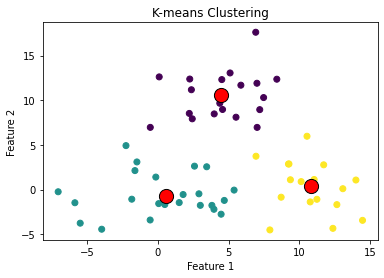

In [164]:
# Visualiser les clusters
plt.scatter(P[:, 0], P[:, 1], c=y_kmeans, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='o', s=200, edgecolor='k', c='red')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [165]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.8, 1)
contraintes = [myc1]
centers = kmeans.cluster_centers_

centers = centers.reshape(n_clusters*2)
x0 = np.tile(centers, int(N/n_clusters))
options = {"maxiter" : 10000}


t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes, options = options)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
solution_position = resultat.x
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))

/home/ines/.local/lib/python3.10/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../../../tmp/ipykernel_10373/2466845036.py", line 7:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


temps :  2.8642148971557617
     fun: 10.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 1241
  status: 1
 success: True
       x: array([ 4.89809695, 12.57592799,  4.1254192 , -2.6710007 , 10.32630884,
       -1.40587353,  8.22290904, 12.19197212, -2.15669164, -3.60052593,
       13.55849749,  0.67837225,  2.26309449, 12.34154304,  1.67120994,
       -1.84173683,  7.77534099, -3.80002751,  4.55961298,  8.93111758,
        2.27749445, -0.82470819,  9.03168232, -0.95004702,  2.47679713,
        7.85672434, -0.43645473, -2.75293118,  9.25980386,  1.65275931,
        6.87428303, 11.07365928,  3.38279899,  2.48284757, 11.64813004,
        2.53277649])
Résultat de l'optimisation: 10.0
Valeurs optimales des variables: [ 4.89809695 12.57592799  4.1254192  -2.6710007  10.32630884 -1.40587353
  8.22290904 12.19197212 -2.15669164 -3.60052593 13.55849749  0.67837225
  2.26309449 12.34154304  1.67120994 -1.84173683  7.77534099 -3.80002751
  4.55961298  8.93111758  2.277

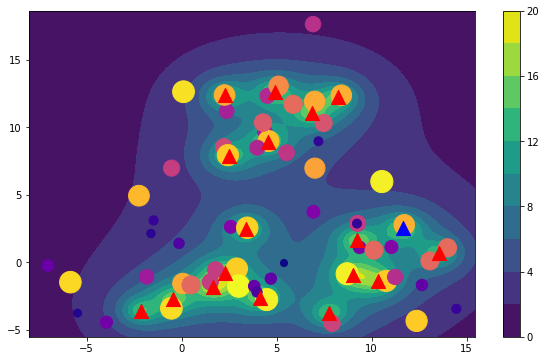

In [166]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N-1) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 200, label = "sattelites")
coord_sat_perdu = [resultat.x[2*N-2], resultat.x[2*N+1-2]]
ax.scatter(coord_sat_perdu[0],coord_sat_perdu[1], marker = "^", color = "blue", s = 200, label = "sattelites")

solution_position = resultat.x


On a ici repris exactement le même problème que dans S3-3. Maintenant, on va enlever un satelite et voir comment va évoluer le schéma. Le but est que dans un premier temps la couverture réseau soit maintenue. Le problème contiendra donc 2N-2 variables et aura pour conditions initiales les anciennes positions. On a mis en vert le satellite qui va disparaître.

In [167]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
contraintes = [myc1]

x0 = solution_position[:2*N-2]

options = {"maxiter" : 10000}

t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes, options = options)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
solution_position = resultat.x
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))

temps :  2.7538540363311768
     fun: 10.0
   maxcv: 0.003685916626160912
 message: 'Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.'
    nfev: 4108
  status: 4
 success: False
       x: array([ 5.14100034, 12.48704237,  4.3149816 , -2.53411331, 10.5620067 ,
       -0.89455887,  8.18527722, 12.1480823 , -2.71811923, -3.24141242,
       13.32762003,  0.88677572,  2.33506003, 12.25080381,  0.72787549,
       -1.44258765,  8.16258465, -3.59363326,  4.73299444,  8.8399966 ,
        3.01872511, -1.11113452,  8.9656008 , -0.39532439,  2.50198088,
        7.85500859, -0.50808003, -3.14311295, 11.08860375,  2.73969056,
        6.83235746, 10.98043785,  3.61274941,  2.53043463])
Résultat de l'optimisation: 10.0
Valeurs optimales des variables: [ 5.14100034 12.48704237  4.3149816  -2.53411331 10.5620067  -0.89455887
  8.18527722 12.1480823  -2.71811923 -3.24141242 13.32762003  0.88677572
  2.33506003 12.25080381  0.72787549 -1.44258765  8.162584

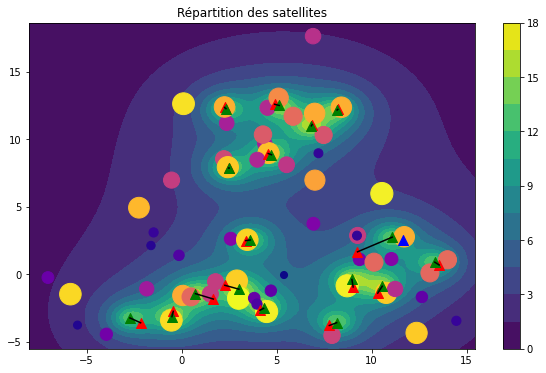

In [168]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N-1) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N-1) : 
    ax.scatter(x0[2*i], x0[2*i+1], marker = "^", color = "red", s = 100, label = "old sattelites")
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "green", s = 100, label = "new sattelites")
    ax.plot([x0[2*i], resultat.x[2*i]],[x0[2*i+1], resultat.x[2*i+1]], color = "black")
ax.scatter(coord_sat_perdu[0], coord_sat_perdu[1], marker = "^", color = "blue", s = 100, label = "sattelites")
plt.title("Répartition des satellites")
plt.savefig("LostSateSol.pdf")
new_solution = resultat.x


#On aimerait aussi plot des lignes allant de la position initiale des satellites à la position finale


In [169]:
x_min = np.min(xp)
x_max = np.max(xp)

y_min = np.min(yp)
y_max = np.max(yp)


@numba.jit(nopython = True, parallel = True)
def objectif(x) :
    sum = 0
    for i in range(int(len(x)/2)) : 
        sum += (x[2*i] - solution_position[2*i])**2 + (x[2*i+1] - solution_position[2*i+1])**2
    return sum

        
    
    

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)


In [170]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
contraintes = [myc1]

x0 = solution_position[:2*N-2]

options = {"maxiter" : 10000}

t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes, options = options)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
solution_position = resultat.x
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))
new_solution = resultat.x

/home/ines/.local/lib/python3.10/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../../../tmp/ipykernel_10373/585823227.py", line 8:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


temps :  1.558091163635254
     fun: 9.99999999983255e-09
   maxcv: 0.0036859166940320653
 message: 'Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.'
    nfev: 251
  status: 4
 success: False
       x: array([ 5.14101693, 12.48705471,  4.31498946, -2.53409206, 10.56203098,
       -0.89454247,  8.18527561, 12.14809772, -2.71811158, -3.24140466,
       13.32756923,  0.88676299,  2.33506325, 12.25080587,  0.7278788 ,
       -1.44258957,  8.16258554, -3.59362907,  4.73298963,  8.83998451,
        3.01873816, -1.11115731,  8.96562054, -0.39531824,  2.5019833 ,
        7.85499047, -0.50807762, -3.14314526, 11.08864386,  2.73968652,
        6.83233575, 10.98042103,  3.61274843,  2.53043393])
Résultat de l'optimisation: 9.99999999983255e-09
Valeurs optimales des variables: [ 5.14101693 12.48705471  4.31498946 -2.53409206 10.56203098 -0.89454247
  8.18527561 12.14809772 -2.71811158 -3.24140466 13.32756923  0.88676299
  2.33506325 12.25080587  0

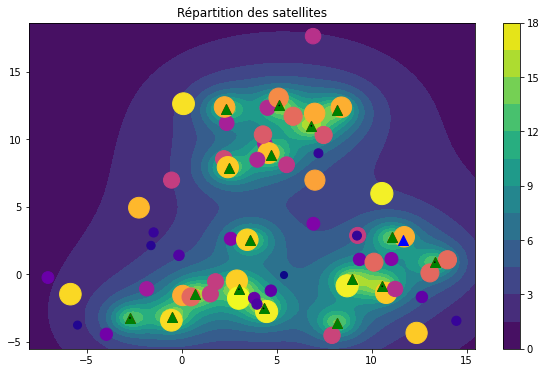

In [171]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N-1) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N-1) : 
    ax.scatter(x0[2*i], x0[2*i+1], marker = "^", color = "red", s = 100, label = "old sattelites")
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "green", s = 100, label = "new sattelites")
    ax.plot([x0[2*i], resultat.x[2*i]],[x0[2*i+1], resultat.x[2*i+1]], color = "black")
ax.scatter(coord_sat_perdu[0], coord_sat_perdu[1], marker = "^", color = "blue", s = 100, label = "sattelites")
plt.title("Répartition des satellites")
plt.savefig("LostSateSol2.pdf")
new_solution = resultat.x

#On aimerait aussi plot des lignes allant de la position initiale des satellites à la position finale


In [172]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
contraintes = [myc1]

x0 = solution_position[:2*N-4]

options = {"maxiter" : 10000}

t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes, options = options)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
solution_position = resultat.x
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))

temps :  4.953877925872803
     fun: 0.6402034224665886
   maxcv: 0.03950409308623348
 message: 'Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.'
    nfev: 7391
  status: 4
 success: False
       x: array([ 5.30000786, 12.42891649,  4.2621584 , -2.47551614, 10.51733448,
       -0.90825105,  8.09435463, 12.15833125, -2.55637788, -3.31763466,
       13.30214606,  0.90112344,  2.39192945, 12.19400225,  0.77883759,
       -1.07019004,  7.98044035, -3.53901185,  4.61863934,  8.50301124,
        3.00801594, -1.03356839,  8.88795059, -0.3230293 ,  2.58062609,
        7.69043424, -0.4486101 , -3.03793538, 11.05560514,  2.74471725,
        6.50746776, 10.69851577])
Résultat de l'optimisation: 0.6402034224665886
Valeurs optimales des variables: [ 5.30000786 12.42891649  4.2621584  -2.47551614 10.51733448 -0.90825105
  8.09435463 12.15833125 -2.55637788 -3.31763466 13.30214606  0.90112344
  2.39192945 12.19400225  0.77883759 -1.07019004  7.980440

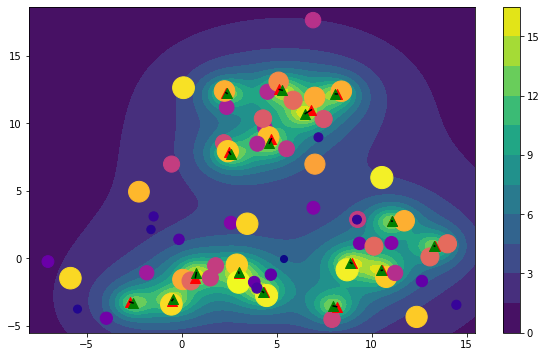

In [173]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N-2) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N-2) : 
    ax.scatter(x0[2*i], x0[2*i+1], marker = "^", color = "red", s = 100, label = "old sattelites")
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "green", s = 100, label = "new sattelites")
    ax.plot([x0[2*i], resultat.x[2*i]],[x0[2*i+1], resultat.x[2*i+1]], color = "black")

new_solution = resultat.x


In [174]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
contraintes = [myc1]

x0 = solution_position[:2*N-6]

options = {"maxiter" : 10000}

t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes, options = options)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
solution_position = resultat.x
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))

temps :  1.915604829788208
     fun: 1.2003304599813327
   maxcv: 0.0573595956845212
 message: 'Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.'
    nfev: 3384
  status: 4
 success: False
       x: array([ 5.76946104, 12.51086046,  4.26269109, -2.46019965, 10.50747217,
       -0.90116754,  7.99729528, 11.93010985, -2.53994134, -3.31804253,
       13.29178936,  0.91250881,  2.58247809, 12.27838672,  0.77213675,
       -1.00318872,  7.98280672, -3.52399279,  5.06946174,  9.26089767,
        3.01420249, -1.023913  ,  8.87500857, -0.29603601,  2.67648383,
        7.94304056, -0.43963444, -3.01762698, 11.04453198,  2.7585993 ])
Résultat de l'optimisation: 1.2003304599813327
Valeurs optimales des variables: [ 5.76946104 12.51086046  4.26269109 -2.46019965 10.50747217 -0.90116754
  7.99729528 11.93010985 -2.53994134 -3.31804253 13.29178936  0.91250881
  2.58247809 12.27838672  0.77213675 -1.00318872  7.98280672 -3.52399279
  5.06946174  9.260

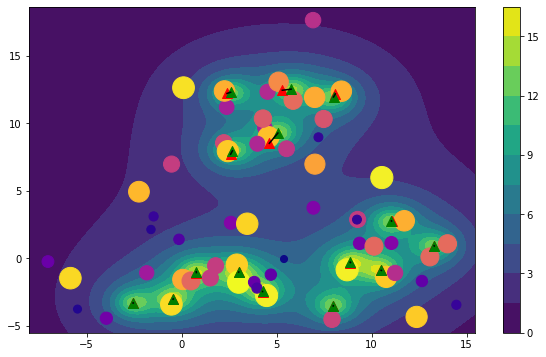

In [175]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N-3) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N-3) : 
    ax.scatter(x0[2*i], x0[2*i+1], marker = "^", color = "red", s = 100, label = "old sattelites")
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "green", s = 100, label = "new sattelites")
    ax.plot([x0[2*i], resultat.x[2*i]],[x0[2*i+1], resultat.x[2*i+1]], color = "black")

new_solution = resultat.x
